<a href="https://colab.research.google.com/github/LuisaBeccar/proyecto_nlp/blob/main/TP_DCIII_LuisaBeccarVarela_nlp_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

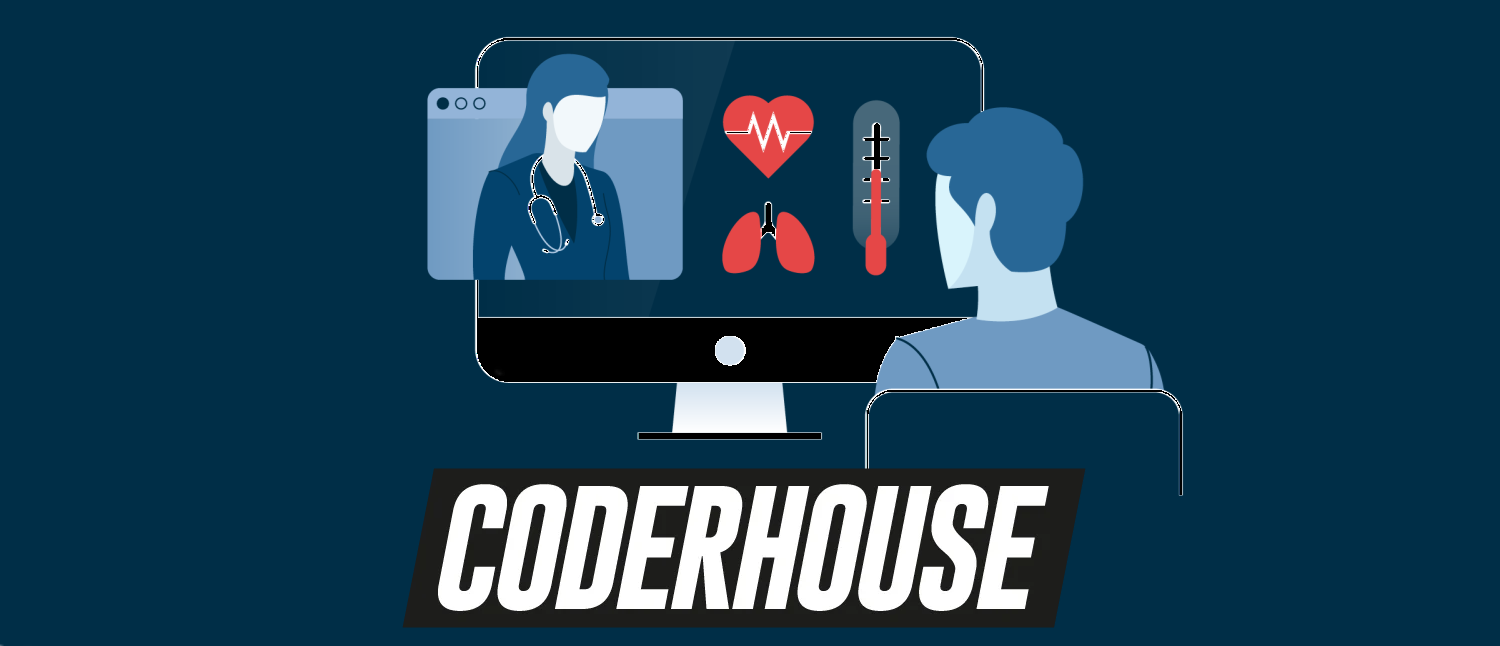

# CoderHouse: NLP & deep learning para la Ciencia de Datos
## Comision: 61195 - Nov-Dic 2024
## Luisa Beccar Varela

  ## Clasificación de enfermedades segun descripción de sintomas. <br>


**Introducción** <br>

Metas:<br>
  Combinar lo que aprendido  sobre el procesamiento de texto en lenguage natural y los modelos de clasificación de machine learning para desarrollar algoritmos capaces de clasificar los sintomas descripctos en especialidades, que podria aplicarse a nuevos sintomas introducidos por new inputs. Usare herramientas de vectorizacion con distintos parametros (Count Vectorizer con stop words, lematizer y ngramas), modelos de machine learning para problemas de clasificacion: Logistic Regression, Random  Forest, Support Vector Machine y Gradient Boosting; cross validation con Stratified K fold, y busqueda de hiperparámetros con Halving Random Search.
  Para el mejor algoritmo de Logistic Regression buscare los coeficientes de los ngramas de cada categoria.<br>
  <br>

**Contexto empresarial**<br>
 Un científico de datos en una gran empresa de telemedicina, que tiene miles de llamadas de pacientes que describen sus sintomas cada día.

La empresa quiere identificar de manera automatica la especialidad a la cual deberia deribar a cada pacinete que consulta de manera automatica segun la enfermedad que esté describiendo.

Para resolver el problema, tomaré un conjunto de datos con diagnosticos ya decifrados y entrenaré un modelo de machine learning que genere luego las pedicciones.
Disclaimer: no se sabe quien realizo la clasificacion de enfermedades por lo que la validez de las predicciones quedará entre otras cosas sujeta a si eso fue realizado correctamente.
<br>

Paso a paso:
<br>
- Dataset: de [kaggle](https://www.kaggle.com/datasets/krish0202/symptom-based-disease-labeling-datasetcsv) que descargue en mi [github](https://github.com/LuisaBeccar/proyecto_nlp/blob/main/Symptom2DiseaseKaggle.csv) de 1200 registros: descripcion y clasificacion.
Disclaimer: es una base bastante pequeña y esto afectara la capacidad de prediccion de nuevos registros

- Clasificar las 24 enfermedades en 5 subcategorias.

- Dividir el dataset en set de testeo y entrenamiento.

- Instanciar los modelos, sus hiperparamentros, el Stratified K Fold, y los vectorizadores.
    - Quise hacer que se prueben los 5 clasificadores con los 4 modelos con sus busquedas de hiperparamtros y SKF, pero luego de horas no concluia, por lo que dividi el problema en dos pasos para probar varias opciones aunque no todas.
    - Primero corri el Logistic Regression para cada uno de los 5 vectorizadores. Luego corri el vectorizador que salio con mejor accuracy en los 3 modelos restantes.

- Para la mejor combinacion modelo-vectorizador, que fue un Logistic Regression, calculé los coeficientes de los bigramas de cada categoria de enfermedades.

- Para terminar, propongo un espacio de prueba con nuevos inputs y para que el lector pruebe escribiendo una descripcion en ingles y el mejor modelo prediga.


In [ ]:
%%capture
# librerias

import pandas as pd
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, KFold, GridSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer, WordNetLemmatizer, LancasterStemmer
from nltk import word_tokenize
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
import matplotlib.pyplot as plt



### Preprocesamineto 1

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/LuisaBeccar/proyecto_nlp/refs/heads/main/Symptom2DiseaseKaggle.csv")
df.drop(columns="Unnamed: 0", inplace=True)
df.rename(columns={"text":"symptoms", "label":"illness"}, inplace=True)
df

,illness,symptoms
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,Psoriasis,I have been experiencing joint pain in my fing...
3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,Psoriasis,"My nails have small dents or pits in them, and..."
...,...,...
1195,diabetes,I'm shaking and trembling all over. I've lost ...
1196,diabetes,"Particularly in the crevices of my skin, I hav..."
1197,diabetes,I regularly experience these intense urges and...
1198,diabetes,"I have trouble breathing, especially outside. ..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   illness   1200 non-null   object
 1   symptoms  1200 non-null   object
dtypes: object(2)
memory usage: 18.9+ KB


In [ ]:
df.symptoms.value_counts()
# veo que hay descripciones repetidas

,count
symptoms,
"I've been feeling extremely scratchy, sick, and worn out. In addition, I've lost weight and have a temperature. My urine is dark, and my skin has turned yellow. Additionally, I have been experiencing stomach pain.",4
I've been feeling really weak in my muscles and my neck has been really stiff. My joints have been swelling up and it's hard for me to move around without feeling stiff. Walking has been really painful too.,3
"I've been constipated and it's really hard to go to the bathroom. When I do go, it hurts and my stool has been bloody. I've also been having some pain in my butt and my anus has been really itchy and irritated.",3
"I've been experiencing stiffness and weakness in my neck muscles recently. Since my joints have grown, it's hard for me to walk without getting stiff. Additionally, walking has been extremely uncomfortable.",2
"Since I've been constipated, using the restroom has been quite challenging. When I do go, it aches and I've had blood in my stool. My anus has been quite itchy and irritating, and I've also been experiencing some discomfort in my butt.",2
...,...
"I've been experiencing severe weariness and a sickly sensation. My throat has been really painful and I've had a fairly severe cough. My nose has been quite stuffy, and I've had significant sinus pressure. I'm really miserable and extremely exhausted.",1
I've been feeling really sick and I've had a lot of fatigue. I've had a really bad cough and my throat has been really sore. I've had a lot of sinus pressure and my nose has been really congested. I just feel really run down and miserable.,1
"I've been quite exhausted and ill. My throat has been quite painful, and I've had a fairly nasty cough. I've got a lot of chills and a pretty high temperature. Simply put, I feel really run down and feeble.",1


In [ ]:
# elimino los duplicados
df.drop_duplicates(inplace=True)
df.symptoms.value_counts()

,count
symptoms,
"I have been experiencing a skin rash on my arms, legs, and torso for the past few weeks. It is red, itchy, and covered in dry, scaly patches.",1
I've recently been dealing with an itching rash on my skin. It's covered in pus-filled pimples and blackheads. My skin has also been quite sensitive.,1
"I have been experiencing intense itching, vomiting, and fatigue. I have also lost weight and have a high fever. My skin has turned yellow and my urine is dark. I have also been experiencing abdominal pain.",1
"Back pain, a productive cough, and muscle weakness have been bothering me. I have issues with dizziness and uneven balance, and my neck hurts.",1
"I have been struggling with back pain, a productive cough, and weakness in my muscles. My neck is sore and I have had problems with dizziness and unsteady balance.",1
...,...
"I can't stop coughing and I'm freezing. My sinuses are completely blocked, and I'm inundated with mucous. My chest hurts, and I'm unable to smell anything. My muscles are also really achy.",1
"I'm coughing nonstop and am really chilly. My mucus production is excessive, and my sinuses are fully clogged. I can't smell anything, and my chest hurts. My muscles are quite painful as well.",1
I can't stop coughing and I feel really cold. My sinuses are all blocked and I have a lot of mucus. My chest hurts and I can't smell anything. My muscles are also really sore.,1


In [ ]:
# cuento cuantas descripciones de cada illness hay
df.illness = df.illness.str.lower()
df.illness.value_counts()


,count
illness,
psoriasis,50
varicose veins,50
peptic ulcer disease,50
drug reaction,50
allergy,50
urinary tract infection,50
hypertension,50
diabetes,50
fungal infection,50


In [ ]:
enfermedades = df.illness.value_counts().reindex(df.illness.value_counts().index)


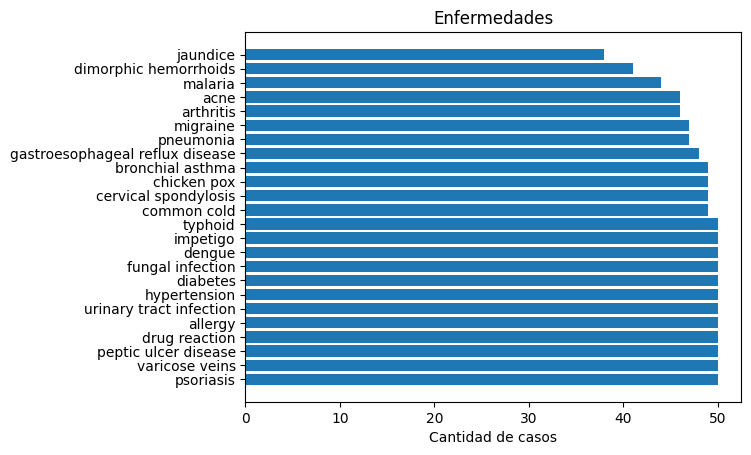

In [ ]:
fig = plt.barh(enfermedades.index, enfermedades.values)
plt.title("Enfermedades")
plt.xlabel("Cantidad de casos")
plt.show()

Como me parecen muchas categorias y quiero simplificar mi problema voy a subclasificar estas enfermedades yo misma

In [ ]:
enfermedades.to_csv("enfermedades.csv")

In [ ]:
#luego de hacer la clasificacion, subo el archivo csv creado

enf_clas = pd.read_csv("https://raw.githubusercontent.com/LuisaBeccar/proyecto_nlp/refs/heads/main/enfermedades_clasificadas.csv")
enf_clas.illness = enf_clas.illness.str.lower()
enf_clas.clasificacion = enf_clas.clasificacion.str.lower()
enf_clas

,illness,clasificacion
0,psoriasis,dermatology
1,varicose veins,dermatology
2,peptic ulcer disease,gastroenterology
3,drug reaction,dermatology
4,allergy,dermatology
5,urinary tract infection,infectology
6,hypertension,cronic disease
7,diabetes,cronic disease
8,fungal infection,infectology
9,dengue,infectology


In [ ]:
# mergeo el dataset de las descripciones e illness con el dataset de subclasificaciones para que me ponga una nueva columna con mi subclasificacion segun la ilness
df = pd.merge(df, enf_clas, on="illness", how="left")
# elimino la columna de illness que no voy a usar
df.drop(columns="illness", inplace=True)
df

,symptoms,clasificacion
0,I have been experiencing a skin rash on my arm...,dermatology
1,"My skin has been peeling, especially on my kne...",dermatology
2,I have been experiencing joint pain in my fing...,dermatology
3,"There is a silver like dusting on my skin, esp...",dermatology
4,"My nails have small dents or pits in them, and...",dermatology
...,...,...
1148,I'm shaking and trembling all over. I've lost ...,cronic disease
1149,"Particularly in the crevices of my skin, I hav...",cronic disease
1150,I regularly experience these intense urges and...,cronic disease
1151,"I have trouble breathing, especially outside. ...",cronic disease


In [ ]:
# quiero mirar como quedaron distribuidas mis categorias
clasificadas = df.clasificacion.value_counts().reindex(df.clasificacion.value_counts().index)
clasificadas

,count
clasificacion,
infectology,389
dermatology,296
cronic disease,242
gastroenterology,177
traumatology,49


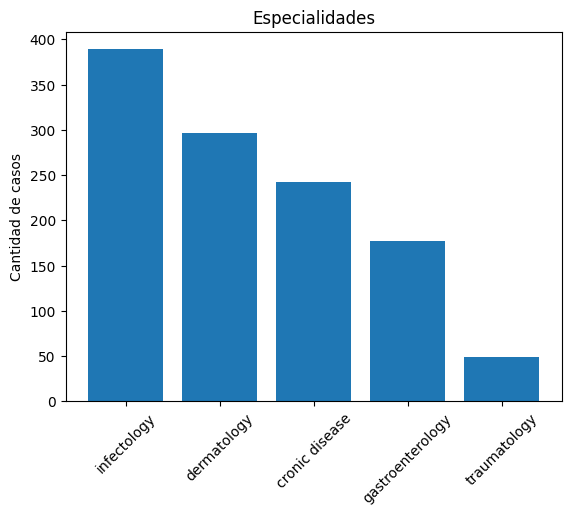

In [ ]:
import matplotlib.pyplot as plt

fig = plt.bar(clasificadas.index, clasificadas.values)
plt.xticks(rotation=45)
plt.title("Especialidades")
plt.ylabel("Cantidad de casos")
plt.show()

Quedo desbalanceado: las descripciones traumatologicas son poquitas

### Preprocesamineto 2

Del dataset calsificadas, resultado de preprocesamiento 1, avanzo con el analisis de texto

In [ ]:
# separo las descripciones y las etiquetas
X = df.symptoms
y = df.clasificacion

In [ ]:
# Train-Test sets. No tocar el test hasta el final.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)# con stratify espero me tome los conjuntos de datos para corregir el disbalance de clases

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((922,), (231,), (922,), (231,))

Para probar distintas practicas de procesamiento de texto: stop-words, bigramas, trigramas, stematizer, creo 5 vectorizadores distintos. <br>

En los distinto vctorizadores voy mezclando metodos: <br>
  - Eliminacion de stopwords con _stop_words="english"_ <br>
  - Ngramas de distintos rangos:
      - _ngram_range=(1,2)_
      - _ngram_range=(1,3)_
  - Lematizacion con _def lematizer_words_
  - Preprocesador para sacar caracteres no deseados y poner todo en minusculas <br>

```
      def preprocess_text(df):
         df = df.lower()
         df = re.sub(r'\d+', '', df)
         return df

```


In [ ]:
# defino este preprocesador para los dos primeros vectorizadores (el tercero lo escribo distino, ver luego)
import re
def preprocess_text(df):
         df = df.lower()
         df = re.sub(r'\d+', '', df)
         return df

In [ ]:
# Fitear y transsformar el train dataset en 3 tipos de vectorizadores

# 1 -Bigramas sin stopwords
count_vectorizer1 = CountVectorizer(preprocessor=preprocess_text, ngram_range=(1,2), stop_words="english")
X_train_v1 = count_vectorizer1.fit_transform(X_train)
X_test_v1 = count_vectorizer1.transform(X_test)

# 2 -Trigramas sin stopqords
count_vectorizer2 = CountVectorizer(preprocessor=preprocess_text, ngram_range=(1,3), stop_words="english")
X_train_v2 = count_vectorizer2.fit_transform(X_train)
X_test_v2 = count_vectorizer2.transform(X_test)


# 3 -Bigramas sin stopwords lematizado
lemmatizer = WordNetLemmatizer()
analyzer = CountVectorizer().build_analyzer()
def lematizer_words(doc):  # en este caso meto los lower y quitador de caract no deseados en el lematizer asi queda un solo preprocesador
    doc = doc.lower()
    doc = re.sub(r'\d+', '', doc)
   # return (lemmatizer.lemmatize(w) for w in analyzer(doc))
    return " ".join(lemmatizer.lemmatize(w) for w in analyzer(doc))# Join the lemmatized words back into a string

count_vectorizer3 = CountVectorizer(ngram_range=(1,2), stop_words="english", preprocessor=lematizer_words ) #
X_train_v3 = count_vectorizer3.fit_transform(X_train)
X_test_v3 = count_vectorizer3.transform(X_test)


# ------

vectorizadores = {"CV1": (count_vectorizer1, X_train_v1, X_test_v1),
                  "CV2": (count_vectorizer2, X_train_v2, X_test_v2),
                  "CV3": (count_vectorizer2, X_train_v3, X_test_v3)}


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'wa'] not in stop_words.
  warnings.warn(


In [ ]:
# tabla con los parametros de cada vectorizador

V1 = ["Vectorizer1", "lower", "sin", "english", "1,2","-"]
V2 = ["Vectorizer2", "lower", "sin", "english", "1,3","-"]
V3 = ["Vectorizer3", "lower", "sin","english", "1,2", "lemmatizer"]

tablaV = pd.DataFrame([V1,V2,V3], columns=["Vectorizador", "Case", "Caract. Especiales", "Stopwords", "Ngramas", "Preprocesamiento"])
display(tablaV)

,Vectorizador,Case,Caract. Especiales,Stopwords,Ngramas,Preprocesamiento
0,Vectorizer1,lower,sin,english,"1,2",-
1,Vectorizer2,lower,sin,english,"1,3",-
2,Vectorizer3,lower,sin,english,"1,2",lemmatizer


### Visualizacion WorldCloud "Symptoms"
teniendo el mejor vectorizador, podemos hacer el grafico de nube de palabras

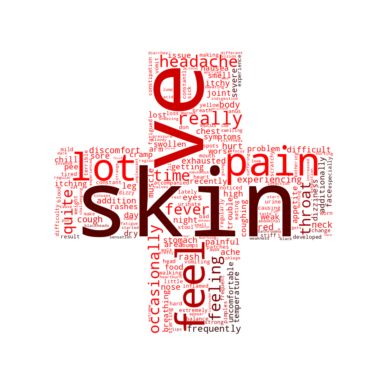

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
import numpy as np
import matplotlib.pyplot as plt

# con el count_vectorizer que mejor resultado haya dado tomo todos los comentarios de sintomas X
X
texto = ' '.join(X)
X_vect1 = count_vectorizer1.transform([texto])
# Convertir la matriz e string de nuevo
feature_names = count_vectorizer1.get_feature_names_out()
textoV1 = ' '.join([feature_names[i] for i in X_vect1.toarray()[0].nonzero()[0]])

# lo vamos a poner en una mascara con forma de cruz medica

url="https://github.com/LuisaBeccar/proyecto_nlp/blob/main/cruz.png?raw=true" # click derecho sobre imagen, copiar ruta de imagen
import requests
from io import BytesIO
from PIL import Image

page = requests.get(url)
my_mask = Image.open(BytesIO(page.content))

cross_color = np.array(my_mask)
cross_mask = cross_color.copy()
cross_mask[cross_mask.sum(axis=2) == 0] = 255
cross = WordCloud(margin=0, mask = cross_mask, background_color="white").generate(textoV1)

image_colors = ImageColorGenerator(cross_color)
cross.recolor(color_func = image_colors)

plt.imshow(cross, interpolation='bilinear')
plt.axis('off')
plt.show()
cross.to_file("./cross.png")

In [ ]:
# importo modelos
from sklearn.linear_model import LogisticRegression
# solo usare el LR
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC


# importo halving gridsearchsv para hiperparametros
from sklearn.experimental import enable_halving_search_cv; # noqa
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV
# instancio el Stratified K fold que usare para cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


**Disclaimer:**
<br>
luego de intentar hacer todos los modelos con los 5 vectorizadores y que estuviera horas sin concluir, decido usar primero Logistic Regression y con este probar los 5 vectorizadores.<br>

Después correré el mejor vectorizador de LR con los 4 modelos (seria esta vez sin el LR ya que ya se hizo en el paso previo)

In [ ]:
# instancio modelos

LR_model = LogisticRegression()
RF_model = RandomForestClassifier()
GB_model = GradientBoostingClassifier()
SVC_model = SVC()


In [ ]:
# grillas de hiperparametros para cada modelo

# param grid log_reg
params_log_reg = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 500],
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'l1_ratio': [0.1, 0.5, 0.9]  # Add l1_ratio for elasticnet
}

# params grid rf
params_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# params grid svm
params_svm = {
    'C':[1,10], # (el codigo que habia encontrado usaba tambien 100, 1000, pero me tardaria mucho entonces los saque)
    'gamma':[1,0.1,0.001,0.0001],
    'kernel':['linear','rbf']
    }


# params grid gb
param_gb = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'subsample': [0.7, 0.8, 1.0]
     }


### A mano cada vectorizador como seria:


#### LR V1

In [ ]:
#log_reg V1
%%capture
search_log_reg1 = HalvingRandomSearchCV(LR_model, params_log_reg, cv=skf, factor=2, scoring='accuracy', random_state=42, n_jobs=-1) # instancio el buscador de hiperparametros para mi modelo (en este caso el regresion logistica) con la grilla que hice para él y par aque el score que optimice sea el accuracy, con el cv=skf definido arroba en Stratified K Fold Cross Validation
search_log_reg1.fit(X_train_v1, y_train) # aplico el metodo a mis datos

best_model_log_reg1 = search_log_reg1.best_estimator_ # obtener el modelo con sus mejores hiperparametos para el scoring elegido

y_pred_log_reg1 = best_model_log_reg1.predict(X_test_v1) # para luego obtener las metricas de clasificacion:
accuracy_log_reg1 = accuracy_score(y_test, y_pred_log_reg1)


In [ ]:
#log_reg V1
print(f"Classification Report for Logistic Regression 1:\n", classification_report(y_test, y_pred_log_reg1))
print(f"Best Model Logistic Regression V1:", best_model_log_reg1)
search_log_reg1.best_params_ # para chequear que sean como los que indica el best_model

Classification Report for Logistic Regression 1:
                   precision    recall  f1-score   support

  cronic disease       0.90      0.96      0.93        49
     dermatology       0.98      0.97      0.97        59
gastroenterology       1.00      1.00      1.00        35
     infectology       0.99      0.97      0.98        78
    traumatology       1.00      0.90      0.95        10

        accuracy                           0.97       231
       macro avg       0.97      0.96      0.97       231
    weighted avg       0.97      0.97      0.97       231

Best Model Logistic Regression V1: LogisticRegression(C=100, l1_ratio=0.9, max_iter=500, solver='liblinear')


{'solver': 'liblinear',
 'penalty': 'l2',
 'max_iter': 500,
 'l1_ratio': 0.9,
 'C': 100}

#### LR V2

In [ ]:
#log_reg V2
%%capture
search_log_reg2 = HalvingRandomSearchCV(LR_model, params_log_reg, cv=skf, factor=2, scoring='accuracy', random_state=42, n_jobs=-1) # instancio el buscador de hiperparametros para mi modelo (en este caso el regresion logistica) con la grilla que hice para él y par aque el score que optimice sea el accuracy, con el cv=skf definido arroba en Stratified K Fold Cross Validation
search_log_reg2.fit(X_train_v2, y_train) # aplico el metodo a mis datos

best_model_log_reg2 = search_log_reg2.best_estimator_ # obtener el modelo con sus mejores hiperparametos para el scoring elegido

y_pred_log_reg2 = best_model_log_reg2.predict(X_test_v2) # para luego obtener las metricas de clasificacion:
accuracy_log_reg2 = accuracy_score(y_test, y_pred_log_reg2)


In [ ]:
#log_reg V2
print(f"Classification Report for Logistic Regression 2 :\n", classification_report(y_test, y_pred_log_reg2))
print(f"Best Model Logistic Regression V2:", best_model_log_reg2)
search_log_reg2.best_params_ # para chequear que sean como los que indica el best_model

Classification Report for Logistic Regression 2 :
                   precision    recall  f1-score   support

  cronic disease       0.89      0.96      0.92        49
     dermatology       0.98      0.95      0.97        59
gastroenterology       1.00      1.00      1.00        35
     infectology       0.97      0.96      0.97        78
    traumatology       1.00      0.90      0.95        10

        accuracy                           0.96       231
       macro avg       0.97      0.95      0.96       231
    weighted avg       0.96      0.96      0.96       231

Best Model Logistic Regression V2: LogisticRegression(C=100, l1_ratio=0.9, max_iter=500, solver='liblinear')


{'solver': 'liblinear',
 'penalty': 'l2',
 'max_iter': 500,
 'l1_ratio': 0.9,
 'C': 100}

#### LR V3

In [ ]:
#log_reg V3
%%capture
search_log_reg3 = HalvingRandomSearchCV(LR_model, params_log_reg, cv=skf, factor=2, scoring='accuracy', random_state=42, n_jobs=-1) # instancio el buscador de hiperparametros para mi modelo (en este caso el regresion logistica) con la grilla que hice para él y par aque el score que optimice sea el accuracy, con el cv=skf definido arroba en Stratified K Fold Cross Validation
search_log_reg3.fit(X_train_v3, y_train) # aplico el metodo a mis datos

best_model_log_reg3 = search_log_reg3.best_estimator_ # obtener el modelo con sus mejores hiperparametos para el scoring elegido

y_pred_log_reg3 = best_model_log_reg3.predict(X_test_v3) # para luego obtener las metricas de clasificacion:
accuracy_log_reg3 = accuracy_score(y_test, y_pred_log_reg3)


In [ ]:
#log_reg V3
print(f"Classification Report for Logistic Regression 3:\n", classification_report(y_test, y_pred_log_reg3))
print(f"Best Model Logistic Regression V3:", best_model_log_reg3)
search_log_reg3.best_params_ # para chequear que sean como los que indica el best_model

Classification Report for Logistic Regression 3:
                   precision    recall  f1-score   support

  cronic disease       0.90      0.96      0.93        49
     dermatology       0.98      0.95      0.97        59
gastroenterology       1.00      1.00      1.00        35
     infectology       0.97      0.97      0.97        78
    traumatology       1.00      0.90      0.95        10

        accuracy                           0.97       231
       macro avg       0.97      0.96      0.96       231
    weighted avg       0.97      0.97      0.97       231

Best Model Logistic Regression V3: LogisticRegression(C=100, l1_ratio=0.9, max_iter=500, solver='liblinear')


{'solver': 'liblinear',
 'penalty': 'l2',
 'max_iter': 500,
 'l1_ratio': 0.9,
 'C': 100}

Para ver los 3 accuracy scores...

In [ ]:
# ver las accuracys de los 3 vectorizadores en Logistic Regression
accuracysVect = [accuracy_log_reg1, accuracy_log_reg2, accuracy_log_reg3]
accuracies = pd.DataFrame({"Vectorizador": ["V1", "V2", "V3"], "Accuracy": accuracysVect})
accuracies

,Vectorizador,Accuracy
0,V1,0.969697
1,V2,0.961039
2,V3,0.965368


El V1 pareciera tener el mejor score, por lo cual seguiremos con este

In [ ]:
X_train_BEST = X_train_v1
X_test_BEST = X_test_v1

### Probando el mejor vectorizador en los 4 modelos de manera manual seria asi:
(silencio el Logistic Regression que ya se hizo)  

In [ ]:
#log_reg1
%%capture
"""
search_log_reg = HalvingRandomSearchCV(LR_model, params_log_reg, cv=skf, factor=2, scoring='accuracy', random_state=42, n_jobs=-1) # instancio el buscador de hiperparametros para mi modelo (en este caso el regresion logistica) con la grilla que hice para él y par aque el score que optimice sea el accuracy, con el cv=skf definido arroba en Stratified K Fold Cross Validation
search_log_reg.fit(X_train_BEST, y_train) # aplico el metodo a mis datos

best_model_log_reg = search_log_reg.best_estimator_ # obtener el modelo con sus mejores hiperparametos para el scoring elegido

y_pred_log_reg = best_model_log_reg.predict(X_test_BEST) # para luego obtener las metricas de clasificacion:
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
"""

In [ ]:
#log_reg1
"""
print(f"Classification Report for Logistic Regression :\n", classification_report(y_test, y_pred_log_reg))
print(f"Best Model Logistic Regression:", best_model_log_reg)
search_log_reg.best_params_ # para chequear que sean como los que indica el best_model
"""

'\nprint(f"Classification Report for Logistic Regression :\n", classification_report(y_test, y_pred_log_reg))\nprint(f"Best Model Logistic Regression:", best_model_log_reg)\nsearch_log_reg.best_params_ # para chequear que sean como los que indica el best_model\n'

#### RF V1

In [ ]:
# random forest v1
%%capture
search_rf = HalvingRandomSearchCV(RF_model, params_rf, cv=skf, factor=2, scoring='accuracy', random_state=42, n_jobs=-1) # instancio el buscador de hiperparametros para mi modelo (en este caso el regresion logistica) con la grilla que hice para él y par aque el score que optimice sea el accuracy, con el cv=skf definido arroba en Stratified K Fold Cross Validation
search_rf.fit(X_train_BEST, y_train) # aplico el metodo a mis datos

best_model_rf = search_rf.best_estimator_ # obtener el modelo con sus mejores hiperparametos para el scoring elegido

y_pred_rf = best_model_rf.predict(X_test_BEST) # para luego obtener las metricas de clasificacion
accuracy_rf = accuracy_score(y_test, y_pred_rf)

In [ ]:
# random forest v1
print(f"Classification Report for Random Forest :\n", classification_report(y_test, y_pred_rf))
print(f"Best Model Random Forest:", best_model_rf)
search_rf.best_params_ # para chequear que sean como los que indica el best_model

Classification Report for Random Forest :
                   precision    recall  f1-score   support

  cronic disease       0.98      0.92      0.95        49
     dermatology       0.95      0.97      0.96        59
gastroenterology       1.00      1.00      1.00        35
     infectology       0.96      1.00      0.98        78
    traumatology       1.00      0.90      0.95        10

        accuracy                           0.97       231
       macro avg       0.98      0.96      0.97       231
    weighted avg       0.97      0.97      0.97       231

Best Model Random Forest: RandomForestClassifier(max_features='log2', n_estimators=300)


{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': None}

#### SVM V1

In [ ]:
# svm v1
%%capture
search_svc = HalvingRandomSearchCV(SVC_model, params_svm, cv=skf, factor=2, scoring='accuracy', random_state=42, n_jobs=-1) # instancio el buscador de hiperparametros para mi modelo (en este caso el regresion logistica) con la grilla que hice para él y par aque el score que optimice sea el accuracy, con el cv=skf definido arroba en Stratified K Fold Cross Validation
search_svc.fit(X_train_BEST, y_train) # aplico el metodo a mis datos

best_model_svc = search_svc.best_estimator_ # obtener el modelo con sus mejores hiperparametos para el scoring elegido

y_pred_svc = best_model_svc.predict(X_test_BEST) # para luego obtener las metricas de clasificacion
accuracy_svc = accuracy_score(y_test, y_pred_svc)

In [ ]:
# svm v1
print(f"Classification Report for Support Vector Machine Classifier :\n", classification_report(y_test, y_pred_svc))
print(f"Best Model Support Vector Machine Classifier:", best_model_svc)
search_svc.best_params_ # para chequear que sean como los que indica el best_model

Classification Report for Support Vector Machine Classifier :
                   precision    recall  f1-score   support

  cronic disease       0.94      0.94      0.94        49
     dermatology       0.97      0.98      0.97        59
gastroenterology       1.00      1.00      1.00        35
     infectology       0.99      0.99      0.99        78
    traumatology       1.00      0.90      0.95        10

        accuracy                           0.97       231
       macro avg       0.98      0.96      0.97       231
    weighted avg       0.97      0.97      0.97       231

Best Model Support Vector Machine Classifier: SVC(C=10, gamma=0.0001, kernel='linear')


{'kernel': 'linear', 'gamma': 0.0001, 'C': 10}

#### GB V1

In [ ]:
# gb v1
%%capture
search_gb = HalvingRandomSearchCV(GB_model, param_gb, cv=skf, factor=2, scoring='accuracy', random_state=42, n_jobs=-1) # instancio el buscador de hiperparametros para mi modelo (en este caso el regresion logistica) con la grilla que hice para él y par aque el score que optimice sea el accuracy, con el cv=skf definido arroba en Stratified K Fold Cross Validation
search_gb.fit(X_train_BEST, y_train) # aplico el metodo a mis datos

best_model_gb = search_gb.best_estimator_ # obtener el modelo con sus mejores hiperparametos para el scoring elegido

y_pred_gb = best_model_gb.predict(X_test_BEST) # para luego obtener las metricas de clasificacion
accuracy_gb = accuracy_score(y_test, y_pred_gb)

In [ ]:
# gb v1
print(f"Classification Report for Gradient Boosting :\n", classification_report(y_test, y_pred_gb))
print(f"Best Model Gradient Boosting:", best_model_gb)
search_gb.best_params_ # para chequear que sean como los que indica el best_model

Classification Report for Gradient Boosting :
                   precision    recall  f1-score   support

  cronic disease       0.96      0.92      0.94        49
     dermatology       0.97      0.95      0.96        59
gastroenterology       1.00      1.00      1.00        35
     infectology       0.94      0.97      0.96        78
    traumatology       1.00      1.00      1.00        10

        accuracy                           0.96       231
       macro avg       0.97      0.97      0.97       231
    weighted avg       0.96      0.96      0.96       231

Best Model Gradient Boosting: GradientBoostingClassifier(max_depth=7, min_samples_leaf=2, n_estimators=200,
                           subsample=0.7)


{'subsample': 0.7,
 'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 7,
 'learning_rate': 0.1}

resultados Accuracy todos los modelos

In [ ]:
modelos = ["RL", "RF", "SVM", "GB"]
accuracy_hrscv = [accuracy_log_reg1, accuracy_rf, accuracy_svc, accuracy_gb]

resultados_hrscv_skf = pd.DataFrame({'Modelo': modelos, 'Accuracy': accuracy_hrscv})
resultados_hrscv_skf.round(3)

,Modelo,Accuracy
0,RL,0.970
1,RF,0.970
2,SVM,0.974
3,GB,0.961


De todos los modelos con el vectorizador 1, el mejor es el SVM con accuracy score de 0.974. <br>

Quedaria por probar los demas modelos para los otros vectorizadores (V2, V3), pero como se tarda mucho, me quedaré con este resultado.

Se puede ver cómo con distintos vectorizadores y distintos modelos se puede obtener distintas métricas, algunos se ajustan mejor que otros.
<br>

Luego probaremos con inputs de nuevos sintomas y veremos que el modelo falla en predecir las categorias.<br>
Esto podria deberse a que:
 - no se entrenó con una buena cantidad de casos
 - no se sabe si las etiquetas estaban bien puestas en un primer momento.

### New inputs, probando el mejor modelo: SVM V1

Aqui probare el mejor modelo: el Logistic Regression para el vectorizador 1, con los hiperparametros que me arrojo el HR Grid Search en esta prueba (LogisticRegression(C=100, l1_ratio=0.9, max_iter=500, solver='liblinear'))

In [ ]:
inventados = ["running nose and sore throat", "neck pain after working all day in the computer", "a mosquito bite me in the arm and now i have fever and a rash in my back"]

In [ ]:
for i in inventados:
  nueva_prediccion = count_vectorizer1.transform([i])
  print(i)
  print(best_model_svc.predict(nueva_prediccion))

running nose and sore throat
['dermatology']
neck pain after working all day in the computer
['infectology']
a mosquito bite me in the arm and now i have fever and a rash in my back
['dermatology']


### Input new syntom

In [ ]:
new_syntom = input("ingrese sus sintomas en ingles: ")
new_syntomT = count_vectorizer1.transform([new_syntom])
prediccion = best_model_svc.predict(new_syntomT) # LogisticRegression(C=0.1, l1_ratio=0.5, max_iter=500, penalty=None, solver='saga')
prediccion

ingrese sus sintomas en ingles: 2


array(['dermatology'], dtype=object)

Pareciera cometer errores obvios de clasificacion.

Para poner en practica más metodos de analis de texto tomaremos el modelo de Logistic Regresion con el Vectorizador...

### Coeficintes de correlacion LR V1:

Para cada categoria diagnositca, ver los bigramas con mayor correlacion positva y negativa.

In [ ]:
# tomar los coeficientes del modelo best log reg 3
coefficients = best_model_log_reg1.coef_

# tomar los bigramas del count vectorizer 3 sacando stopwords
bigram_features = count_vectorizer1.get_feature_names_out()

# dataframe que guarde los coeficientes para cada bigrama
results = pd.DataFrame(coefficients, columns = bigram_features)

# agregar el nombre de categoria como idicaes
results.index = best_model_log_reg1.classes_

# para cada categoria dame los bigramas con los 10 coeficientes mejores y peores
for category in results.index:
    category_results = results.loc[category].reset_index()
    category_results.columns = ['bigram', 'coefficient']

    # los mejores 10
    top_bigrams = category_results.nlargest(10, 'coefficient')[['bigram', 'coefficient']]
    top_bigrams.columns = ['bigram', 'coefficient_top']

    # los peores 10
    bottom_bigrams = category_results.nsmallest(10, 'coefficient')[['bigram', 'coefficient']]
    bottom_bigrams.columns = ['bigram', 'coefficient_bottom']

    # prints
    display(f'Category: {category}')
    display('Top 10 Bigrams:', top_bigrams)
    display('Bottom 10 Bigrams:', bottom_bigrams)
    print('---')

display("Tabla general de coeficientes", results)

'Category: cronic disease'

'Top 10 Bigrams:'

,bigram,coefficient_top
7398,vision,3.231054
6333,stiff,2.321663
4750,pain dizziness,2.176158
967,chest pain,2.117196
3585,joints,2.065813
1772,dizziness,1.855440
4882,palpitations,1.696093
3045,headache chest,1.684806
3227,hungry,1.613440
3337,increased,1.553860


'Bottom 10 Bigrams:'

,bigram,coefficient_bottom
4722,pain,-2.023304
3254,hurts,-1.753822
3707,legs,-1.597472
976,chills,-1.543074
2239,eyes,-1.452513
1678,discomfort,-1.402378
642,body,-1.394171
4448,night,-1.319982
4415,neck hurts,-1.298803
4514,nose,-1.228135


---


'Category: dermatology'

'Top 10 Bigrams:'

,bigram,coefficient_top
4514,nose,2.730711
3707,legs,2.314292
6190,sores,2.303586
1342,cramps,2.070929
4329,nails,1.902634
5166,pus,1.782130
2274,face,1.779480
863,calves,1.744826
552,blackheads,1.689386
3077,headaches,1.548389


'Bottom 10 Bigrams:'

,bigram,coefficient_bottom
4399,neck,-2.459742
6236,spots,-1.807305
7398,vision,-1.793872
6359,stomach,-1.792634
4915,pee,-1.671703
3040,headache,-1.651327
3517,itching,-1.533199
812,bumps,-1.469776
2417,feeling,-1.394260
7280,ve,-1.369206


---


'Category: gastroenterology'

'Top 10 Bigrams:'

,bigram,coefficient_top
247,anus,2.746490
7581,weight,2.550397
1909,eating,2.297555
710,bowel,2.140928
7728,yellow,2.128958
3933,lost weight,1.829092
3130,heartburn,1.737049
6214,sour,1.660711
6392,stools,1.648445
6359,stomach,1.526022


'Bottom 10 Bigrams:'

,bigram,coefficient_bottom
4514,nose,-1.755922
3040,headache,-1.412587
642,body,-1.314414
3077,headaches,-1.297126
1868,dry,-1.144053
1238,cough,-1.099563
3925,lost appetite,-1.061064
4296,muscles,-1.031691
7203,urinate,-1.020485
2239,eyes,-1.020280


---


'Category: infectology'

'Top 10 Bigrams:'

,bigram,coefficient_top
976,chills,2.721404
4915,pee,2.677711
3925,lost appetite,2.570428
6236,spots,2.110150
812,bumps,1.975785
7434,vomiting,1.959331
43,accompanied,1.929779
559,bladder,1.860507
4152,mild,1.814059
5466,red,1.773699


'Bottom 10 Bigrams:'

,bigram,coefficient_bottom
7728,yellow,-2.179504
7581,weight,-2.030383
247,anus,-1.951823
1799,dizzy,-1.811366
1868,dry,-1.805324
967,chest pain,-1.790298
3585,joints,-1.744948
6662,taste,-1.726359
6190,sores,-1.653700
4222,mouth,-1.499392


---


'Category: traumatology'

'Top 10 Bigrams:'

,bigram,coefficient_top
4399,neck,2.172152
4415,neck hurts,1.955096
7545,weakness,1.733071
1238,cough,1.338176
426,balance,1.112891
3254,hurts,0.984952
4421,neck pain,0.896002
3831,limb,0.895350
3832,limb weakness,0.895350
4722,pain,0.856105


'Bottom 10 Bigrams:'

,bigram,coefficient_bottom
957,chest,-1.326126
5956,skin,-1.077646
2360,feel,-0.961631
3934,lot,-0.951583
5354,really,-0.936148
2498,fever,-0.934558
3585,joints,-0.858493
3040,headache,-0.781475
6333,stiff,-0.759617
6869,time,-0.751360


---


'Tabla general de coeficientes'

,abdomen,abdomen aches,abdomen bothering,abdomen buring,abdomen day,abdomen felt,abdomen feverish,abdomen frequently,abdomen hours,abdomen indigestion,...,yellow skin,yellow urine,yellow ve,yellowish,yesterday,yesterday face,yesterday noticed,yesterday severe,zone,zone head
cronic disease,-0.553228,-0.100577,-0.019696,-0.041574,-0.027810,-0.099905,-0.000517,-0.023069,-0.074709,-0.033505,...,-0.003587,-0.010794,-0.017121,-0.000856,-0.004022,-0.002703,-0.001004,-0.000315,0.270552,0.270552
dermatology,-0.614076,-0.021326,-0.037052,-0.052229,-0.170611,-0.033383,-0.018075,-0.190619,-0.095042,-0.097849,...,-0.002607,-0.036800,0.003900,-0.017904,-0.031658,0.005587,0.003220,-0.040465,-0.058659,-0.058659
gastroenterology,1.226205,-0.018654,0.053755,-0.070725,0.423354,0.059954,-0.020857,0.173404,0.030893,0.237725,...,0.107229,0.483853,0.139881,-0.030278,-0.001433,-0.001605,0.000046,0.000125,-0.015498,-0.015498
infectology,-0.323243,0.118452,-0.008341,0.223413,-0.217653,-0.009264,0.048749,-0.036732,-0.007034,-0.095760,...,-0.113534,-0.633491,-0.107918,0.021086,0.083670,-0.021847,-0.018282,0.123799,-0.176445,-0.176445
traumatology,-0.215697,-0.004227,-0.013334,-0.038834,-0.020675,-0.019492,-0.032047,-0.011587,-0.025881,-0.009098,...,-0.000395,-0.015682,-0.002639,-0.000346,-0.009118,-0.001633,-0.000313,-0.007173,-0.003215,-0.003215


Mirando en detalle las tablas de coeficientes, vemos como hay algunos bigramas que con conocimiento de experto están con pesos superiores a los que uno pensaría para el tipo de enfermedades, por ejemplo: "weakness# y #cough" como el tercro y cuarto en importancia para la categoria "traumatology".<br>
 Asi se entiende que el modelo cometa errores.

## TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
#https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

# Initialize the TF-IDF Vectorizer   + ngrama + min_df (ignorar si no aparece mas de 5 veces) + preprocessor que use en el V3 con lematizacion
vectorizer = TfidfVectorizer(stop_words='english', preprocessor=lematizer_words, ngram_range=(1,2), min_df=5)

# Transform the text data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)



/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'wa'] not in stop_words.
  warnings.warn(


In [ ]:
# log reg con vectorizador tfidf
%%capture
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import  HalvingGridSearchCV, HalvingRandomSearchCV


search_log_reg_tfidf = HalvingRandomSearchCV(LR_model, params_log_reg, cv=skf, factor=2, scoring='accuracy', random_state=42, n_jobs=-1) # instancio el buscador de hiperparametros para mi modelo (en este caso el regresion logistica) con la grilla que hice para él y par aque el score que optimice sea el accuracy, con el cv=skf definido arroba en Stratified K Fold Cross Validation
search_log_reg_tfidf.fit(X_train_tfidf, y_train) # aplico el metodo a mis datos

best_model_log_reg_tfidf = search_log_reg_tfidf.best_estimator_ # obtener el modelo con sus mejores hiperparametos para el scoring elegido

y_pred_log_reg_tfidf= best_model_log_reg_tfidf.predict(X_test_tfidf) # para luego obtener las metricas de clasificacion:
accuracy_log_reg_tfdif = accuracy_score(y_test, y_pred_log_reg_tfidf)


In [ ]:
print(f"Classification Report for LR TFIDF:\n", classification_report(y_test, y_pred_log_reg_tfidf))
print(f"Best Model LR TFIDF:", best_model_log_reg_tfidf)


Classification Report for SVM v3 TFIDF:
                   precision    recall  f1-score   support

  cronic disease       0.94      0.96      0.95        49
     dermatology       0.98      0.93      0.96        59
gastroenterology       0.97      1.00      0.99        35
     infectology       0.96      0.99      0.97        78
    traumatology       1.00      0.90      0.95        10

        accuracy                           0.97       231
       macro avg       0.97      0.96      0.96       231
    weighted avg       0.97      0.97      0.97       231

Best Model SVM v3 TFIDF: LogisticRegression(C=0.1, l1_ratio=0.5, max_iter=500, penalty=None,
                   solver='saga')


Da un mejor accuracy score que los intentados antes. <br>
A probarlo con nuevos inputs...

In [ ]:
inventados = ["running nose and sore throat", "neck pain after working all day in the computer", "a mosquito bite me in the arm and now i have fever and a rash in my back"]

In [ ]:
for i in inventados:
  nueva_prediccion = vectorizer.transform([i])
  print(i)
  print(best_model_log_reg_tfidf.predict(nueva_prediccion))

running nose and sore throat
['dermatology']
neck pain after working all day in the computer
['traumatology']
a mosquito bite me in the arm and now i have fever and a rash in my back
['infectology']


In [ ]:
new_syntom_tfidf = input("ingrese sus sintomas en ingles: ")
new_syntomT_tfidf = vectorizer.transform([new_syntom_tfidf])
prediccion_tfidf = best_model_log_reg_tfidf.predict(new_syntomT_tfidf) # LogisticRegression(C=0.1, l1_ratio=0.5, max_iter=500, penalty=None, solver='saga')
prediccion_tfidf

ingrese sus sintomas en ingles: pain


array(['infectology'], dtype=object)

Bueno, incluso con el TF IDF no funciona bien y comete errores ante nuevos inputs.


**Conclusiones:** <br>

Si bien el mejor modelo tiene buenas metricas de rendimiento, falla al introducirle nuevos inputs.<br>
Por qué sucede esto?
<br>
Probablemente por la reducida cantidad de datos de training, sumado a quizas una mala primera clasificacion de enfermedades.
<br>

Lineas futuras podrian incluir adjuntar más registros a la base de datos de entrenamiento, revisando que estén bien etiquetados.

# Extras

## Busqueda del mejor modelo:
intento de automatizar la busqueda a los 3 vectorizadores para los 4 modelos, todos con SKF y Halving Random Search de hiperparametros.

al no completarse en 6 horas, aborté mision y silencio el codigo para no ser corrido.


In [ ]:
"""
import pandas as pd
from sklearn.experimental import enable_halving_search_cv  # Enable experimental HalvingGridSearchCV
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score

# con los 4 modelos, sus hiperparametros y los 3 vectorizadores instanciados...

models = {
    "LogisticRegression": (LogisticRegression(), params_log_reg),
    "RandomForest": (RandomForestClassifier(), params_rf),
    "GradientBoosting": (GradientBoostingClassifier(), param_gb),
    "SVC": (SVC(), params_svm)
}

vectorizadores = {"CV1": (count_vectorizer1, X_train_v1, X_test_v1),
                  "CV2": (count_vectorizer2, X_train_v2, X_test_v2),
                  "CV3": (count_vectorizer2, X_train_v3, X_test_v3)}


def train_evaluate_models(vectorizers, models, X_train, X_test, y_train, y_test):
    results = []
    reports = {}

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for vec_name, vectorizer_tuple in vectorizers.items():  # loop de para cada vectorizador:  transformar el X_train y X_test, luego indentado, probar cada modelo
        print(f"\nVectorizador: {vec_name}")
        vectorizer = vectorizer_tuple[0]

        X_train_vec = vectorizer.fit_transform(X_train) # Fit y transform el train
        X_test_vec = vectorizer.transform(X_test)       # solo transform el test

        for model_name, (model, param_grid) in models.items():  # para cada vectorizador probar cada modelo
            print(f"Entrenando modelo: {model_name} con {vec_name}")

            grid_search = HalvingGridSearchCV(model, param_grid, scoring='accuracy', cv=skf, verbose=1, n_jobs=-1)
            grid_search.fit(X_train_vec, y_train)

            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test_vec)
            acc = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred, output_dict=True)

            results.append({
                "Vectorizer": vec_name,
                "Model": model_name,
                "Best Params": grid_search.best_params_,
                "Accuracy": acc
            })
            reports[(vec_name, model_name)] = classification_report(y_test, y_pred)

    results_df = pd.DataFrame(results)
    return results_df, reports

# usar la funcion definida y que me de los resultados y reportes
results_df, reports = train_evaluate_models(vectorizadores, models, X_train, X_test, y_train, y_test)
print("\nResultados:")
print(results_df)

# Guardar informes de clasificación
for (vec_name, model_name), report in reports.items():
    print(f"\nInforme para {model_name} con {vec_name}:\n")
    print(report)
"""

'\nimport pandas as pd\nfrom sklearn.experimental import enable_halving_search_cv  # Enable experimental HalvingGridSearchCV\nfrom sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold\nfrom sklearn.metrics import classification_report, accuracy_score\n\n# con los 4 modelos, sus hiperparametros y los 3 vectorizadores instanciados...\n\nmodels = {\n    "LogisticRegression": (LogisticRegression(), params_log_reg),\n    "RandomForest": (RandomForestClassifier(), params_rf),\n    "GradientBoosting": (GradientBoostingClassifier(), param_gb),\n    "SVC": (SVC(), params_svm)\n}\n\nvectorizadores = {"CV1": (count_vectorizer1, X_train_v1, X_test_v1),\n                  "CV2": (count_vectorizer2, X_train_v2, X_test_v2),\n                  "CV3": (count_vectorizer2, X_train_v3, X_test_v3)}\n\n\ndef train_evaluate_models(vectorizers, models, X_train, X_test, y_train, y_test):\n    results = []\n    reports = {}\n\n    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n